## 用N-Gram模型在莎士比亚诗中训练word embedding
N-gram 是计算机语言学和概率论范畴内的概念，是指给定的一段文本中N个项目的序列。
N=1 时 N-gram 又称为 unigram，N=2 称为 bigram，N=3 称为 trigram，以此类推。实际应用通常采用 bigram 和 trigram 进行计算。
本示例在莎士比亚十四行诗上实现了trigram。

# 环境
本教程基于paddle2.0-alpha编写，如果您的环境不是本版本，请先安装paddle2.0-alpha。

In [1]:
import paddle
paddle.__version__

'2.0.0-alpha0'

## 数据集&&相关参数
训练数据集采用了莎士比亚十四行诗，CONTEXT_SIZE设为2，意味着是trigram。EMBEDDING_DIM设为10。

In [57]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10

test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()

## 数据预处理
将文本被拆成了元组的形式，格式为(('第一个词', '第二个词'), '第三个词');其中，第三个词就是我们的目标。

In [58]:
trigram = [((test_sentence[i], test_sentence[i + 1]), test_sentence[i + 2])
           for i in range(len(test_sentence) - 2)]

vocab = set(test_sentence)
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {word_to_idx[word]: word for word in word_to_idx}
# 看一下数据集
print(trigram[:3])


[(('When', 'forty'), 'winters'), (('forty', 'winters'), 'shall'), (('winters', 'shall'), 'besiege')]


## 构建`Dataset`类 加载数据

In [59]:
import paddle
class TrainDataset(paddle.io.Dataset):
    def __init__(self, tuple_data, vocab):
        self.tuple_data = tuple_data
        self.vocab = vocab

    def __getitem__(self, idx):
        data = list(self.tuple_data[idx][0])
        label = list(self.tuple_data[idx][1])
        return data, label
    
    def __len__(self):
        return len(self.tuple_data)

## 组网&训练
这里用paddle动态图的方式组网，由于是N-Gram模型，只需要一层`Embedding`与两层`Linear`就可以完成网络模型的构建。

In [79]:
import paddle
import numpy as np
class NGramModel(paddle.nn.Layer):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramModel, self).__init__()
        self.embedding = paddle.nn.Embedding(size=[vocab_size, embedding_dim])
        self.linear1 = paddle.nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = paddle.nn.Linear(128, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = paddle.reshape(x, [1, -1])
        x = self.linear1(x)
        x = paddle.nn.functional.relu(x)
        x = self.linear2(x)
        x = paddle.nn.functional.softmax(x)
        return x

### 初始化Model，并定义相关的参数。

In [121]:
vocab_size = len(vocab)
embedding_dim = 10
context_size = 2

paddle.enable_imperative()
losses = []
def train(model):
    model.train()
    optim = paddle.optimizer.SGD(learning_rate=0.001, parameter_list=model.parameters())
    for epoch in range(1000):
        # 留最后10组作为预测
        for context, target in trigram[:-10]:
            context_idxs = list(map(lambda w: word_to_idx[w], context))
            x_data = paddle.imperative.to_variable(np.array(context_idxs))
            y_data = paddle.imperative.to_variable(np.array([word_to_idx[target]]))
            predicts = model(x_data)
            # print (predicts)
            loss = paddle.nn.functional.cross_entropy(predicts, y_data)
            loss.backward()
            optim.minimize(loss)
            model.clear_gradients()
        if epoch % 50 == 0:
            print("epoch: {}, loss is: {}".format(epoch, loss.numpy()))
        losses.append(loss.numpy())
model = NGramModel(vocab_size, embedding_dim, context_size)
train(model)

epoch: 0, loss is: [4.631529]
epoch: 50, loss is: [4.6081576]
epoch: 100, loss is: [4.600631]
epoch: 150, loss is: [4.603069]
epoch: 200, loss is: [4.592647]
epoch: 250, loss is: [4.5626693]
epoch: 300, loss is: [4.513106]
epoch: 350, loss is: [4.4345813]
epoch: 400, loss is: [4.3238697]
epoch: 450, loss is: [4.1728854]
epoch: 500, loss is: [3.9622664]
epoch: 550, loss is: [3.67673]
epoch: 600, loss is: [3.2998457]
epoch: 650, loss is: [2.8206367]
epoch: 700, loss is: [2.2514927]
epoch: 750, loss is: [1.6479329]
epoch: 800, loss is: [1.1147357]
epoch: 850, loss is: [0.73231363]
epoch: 900, loss is: [0.49481753]
epoch: 950, loss is: [0.3504072]


## 打印loss下降曲线
通过可视化loss的曲线，可以看到模型训练的效果。

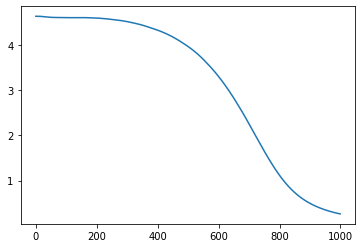

In [123]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(losses)

## 预测
用训练好的模型进行预测。

In [127]:
import random
def test(model):
    model.eval()
    # 从最后10组数据中随机选取1个
    idx = random.randint(len(trigram)-10, len(trigram)-1)
    print('the input words is: ' + trigram[idx][0][0] + ', ' + trigram[idx][0][1])
    x_data = list(map(lambda w: word_to_idx[w], trigram[idx][0]))
    x_data = paddle.imperative.to_variable(np.array(x_data))
    predicts = model(x_data)
    predicts = predicts.numpy().tolist()[0]
    predicts = predicts.index(max(predicts))
    print('the predict words is: ' + idx_to_word[predicts])
    y_data = trigram[idx][1]
    print('the true words is: ' + y_data)
test(model)

the input words is: praise., How
the predict words is: much
the true words is: much
